### Justin Ehly
#### HW7 - NLP
#### Answer explanations and discussion are after the code for each section.

In [1]:
import numpy as np
import requests
import re
import nltk
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd




In [12]:

class scraper():
    '''
        Build web scraper to gather the top 50 comedies from imdb.com
        - gather the titles and individual comedy movie page urls
        - gather the main talent in each movie, mainly director(s) and main star(s)
        - gather the permalinks to <user selected> user comments from each movie's page
        - remove movies that don't have any comments
    '''
    
    def __init__(self, reviews):

        # set imdb header
        self.imdb_header = 'https://www.imdb.com'
        
        # set imdb reviews footer
        self.review_footer = 'reviews?ref_=tt_urv'        
        
        # number of movie reviews per movie
        self.movie_reviews = reviews
    

    # get a list of the 50 comedies listed on the top comedies page on imdb along with the link to each movie's individual page    
    def get_comedies(self):
        # download 50 comedy movie titles and links from imdb
        URL = 'https://www.imdb.com/search/title/?genres=comedy&explore=title_type,genres&pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=3396781f-d87f-4fac-8694-c56ce6f490fe&pf_rd_r=E9DKJDX8CMCD24P485G8&pf_rd_s=center-1&pf_rd_t=15051&pf_rd_i=genre&ref_=ft_gnr_pr1_i_1'
        response = requests.get(URL)
        soup = BeautifulSoup(response.text, 'lxml')

        # grab page contents with movie links and titles
        movies = soup.select('h3.lister-item-header')    

        # get links to each movie page
        movie_links = [link.attrs.get('href') for link in soup.select('h3.lister-item-header a')]
        movie_links = [self.imdb_header + link for link in movie_links]
        movie_links = [link + self.review_footer for link in movie_links]
        self.movie_links = movie_links
        
        # extrap the titles/ actors
        comedy_titles = []
        for idx, movie in enumerate(movies):
            ms = movie.get_text()
            mov = (' '.join(ms.split()).replace('.',''))
            mov = mov.split(' (')[0]
            mov = mov[len(str(idx))+1:]
            comedy_titles.append(mov)
        self.comedy_titles = comedy_titles
        
        # get the main directors and actors
        talent = soup.findAll('p', {'class':''})
        all_talent = []
        for t in talent:  # return a chunk of html with director and stars with titles, needs to be cleaned up
            ms = t.text      # just grab the text from the html
            names = ' '.join(ms.split()).replace('.','')    # extrap the names and titles
            if str.find(names,'|'):         # split up the list by titles ('Director(s)', 'Star(s)')
                names = names.split('|')
            talent = []
            for n in names:
                talent.append(n.split(': ')[1])   # drop the title from each list

            talent = [t.split(', ') for t in talent]
            talent = [item for sublist in talent for item in sublist]

            #clean up spaces at the beginning or end in case they escaped
            talent = [i[1:] if i[0] == ' ' else i[:-1] if i[-1]== ' ' else i for i in talent]
            all_talent.append(talent)
        
        all_talent = [n for m in all_talent for n in m]  # unpack the list of names
        all_talent = set(all_talent) # remove duplicates!
        
        self.talent_names = all_talent
        
    # remove the movies with less than 5 reviews
    def clean_up(self):
        for x,i in enumerate(self.permalinks):
            if len(i) < 5:
                print(self.comedy_titles[x])
                print(len(i))
                self.permalinks.pop(x)
                self.comedy_titles.pop(x)
                self.movie_links.pop(x)
        return self        

    # grab the permalinks from each comedy's move page on imdb    
    def get_permalinks(self):
        self.get_comedies()
        movie_links = self.movie_links
        permalinks = []
        for link in movie_links:
            response = requests.get(link)
            soup = BeautifulSoup(response.text, 'lxml')
            plinks = [self.imdb_header + link.attrs.get('href') for link in soup.select('div.actions.text-muted a') if link.attrs.get('href')[1:7] == 'review']
            plinks = plinks[ 0 : self.movie_reviews ]
            permalinks.append(plinks)
        
        
        self.permalinks = permalinks
        
        self.clean_up()
        
        return self


    
       
# pass how many reviews per movie
imdb = scraper(5).get_permalinks()                



Ms Marvel
0
The Lost City
1
Sonic the Hedgehog 2
0
Everything Everywhere All at Once
1


In [13]:
count_permalinks = len([item for sublist in imdb.permalinks for item in sublist])
print(f'There are {count_permalinks} permalinks for {len(imdb.comedy_titles)} comedies with a total of {len(imdb.talent_names)} unqiue directors and actors from the imdb website')


There are 227 permalinks for 46 comedies with a total of 215 unqiue directors and actors from the imdb website


In [15]:
# Use Beautiful Soup to extract the reviews from each review page within imbd.
links = imdb.permalinks[0]

class movie_reviews():
    def __init__(self, permalinks_list):
        self.permalinks_list = permalinks_list
        
    # cycle through all movies and return a list of lists of movie reviews for each movie
    def get_movie_reviews(self):
        reviews = []
        for single_movie_permalinks in self.permalinks_list:
            single_comedy_reviews = self.movie_review_page_cycling(single_movie_permalinks)
            reviews.append(single_comedy_reviews)
        
        self.reviews = reviews
        return self

    # cycle through each movie's pages of reviews
    def movie_review_page_cycling(self, links):
        reviews = []
        for link in links:
            review = self.get_review(link)
            reviews.append(review)
        
        return reviews

    # get single review
    def get_review(self, link):
        response = requests.get(link)
        soup = BeautifulSoup(response.text, 'lxml')
         
        review =  soup.find('div', {'class':'text show-more__control'}).text
        return review


#reviews = movie_review_page_cycling(links)
#print(f'Reviews for {imdb.comedy_titles[0]}')
#for review in reviews:
#    print(f'{review}\n')

# only pass the first 100 permalinks from the first 20 comedies
reviews = movie_reviews(imdb.permalinks[:21]).get_movie_reviews()

    

In [22]:
#seems one movie is sneaking in with only 2 reviews.
quick_fix = []
for i,r in enumerate(reviews.reviews):
    if len(r)>=5:
        quick_fix.append(r)

In [24]:
len(quick_fix)

20

In [25]:
# unpack the movie reviews into a list of 100 reviews!
movie_reviews = [item for sublist in quick_fix for item in sublist]
len(movie_reviews)

100

In [26]:
import itertools

l = [[i for i in itertools.repeat(imdb.comedy_titles[x],5)] for x in range(20)]
titles = [item for subitem in l for item in subitem]
len(titles)
    

100

In [27]:
movie_reviews[0]

"In 2050, Adam Reed (Ryan Reynolds) steals a time jet to fix a problem in the past. He winds up in 2022 and encounters his 12 year old self (Walker Scobell). His mother Ellie (Jennifer Garner) is dating a year after the death of his father (Mark Ruffalo). The two Adams are helped by his future wife Laura (Zoe Saldana) in their battle against Maya Sorian (Catherine Keener).Ryan Reynolds is being his standard wisecracking self. Saldana is the sexy fighter. Garner is the suffering mom. I like Ryan with his younger self until it runs into a bump in the road. The younger self can't be the zen advisor to the older self. This movie is working very hard to be action-packed fun but the fighting becomes repetitive. This is a middling sci-fi action flick on Netflix that stumbles a few times. Ultimately, I figured that I won't remember this a year from now. Maybe I could steal the time jet."

---
1.	In Python, select any one of the clustering methods covered in this course. Run it over the collection of reviews, and show at least two different ways of clustering the reviews, e.g., changing k in k-Means clustering or changing where you “cut” in Agnes or Diana.  

In [31]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib as mpl
from sklearn.feature_extraction.text import TfidfVectorizer

def kmeans_clustering(reviews, n_clusters):
    vectorizer = TfidfVectorizer(stop_words='english', max_features = 21)  # vectorize and remove stop words
    reviews_vectorized = vectorizer.fit_transform(reviews)
    print(f'The Shape for the vectorized reviews {reviews_vectorized.shape}')
    
    kmeans = KMeans(n_clusters = n_clusters , random_state = 42)
    kmeans.fit(reviews_vectorized)
    clusters = kmeans.predict(reviews_vectorized)
    pca = PCA(n_components=3)
    dense_vect = reviews_vectorized.toarray()
    dims = pca.fit_transform(dense_vect)

    scatter_x = dims[:,0]
    scatter_y = dims[:,1]

    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize = (20,10))


    # color map for NUMBER_OF_CLUSTERS we have
    clrs = ['green', 'blue','red','orange','purple','indianred','chocolate','yellow','lawngreen','fuchsia']

    for i,x in enumerate(clusters):
        ax.scatter(scatter_x[i], scatter_y[i], c = clrs[x], label = x)
        ax.annotate(titles[i],(scatter_x[i], scatter_y[i]) )
  
    ax.set_title(f'K-means {n_clusters} Clusters')
    ax.set_facecolor('white')
    ax.set_xlabel("PCA 0")
    ax.set_ylabel("PCA 1")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
   
    plt.show()
    

# look at most important features
    mreviews = pd.DataFrame(data = dense_vect, columns = vectorizer.get_feature_names_out() )
    mreviews['title'] = titles
    mreviews['cluster'] = clusters
    cols = ['title','cluster'] + [col for col in mreviews if col not in ['title','cluster']]
    mreviews = mreviews[cols]
    
    return reviews_vectorized, clusters, mreviews


The Shape for the vectorized reviews (100, 21)


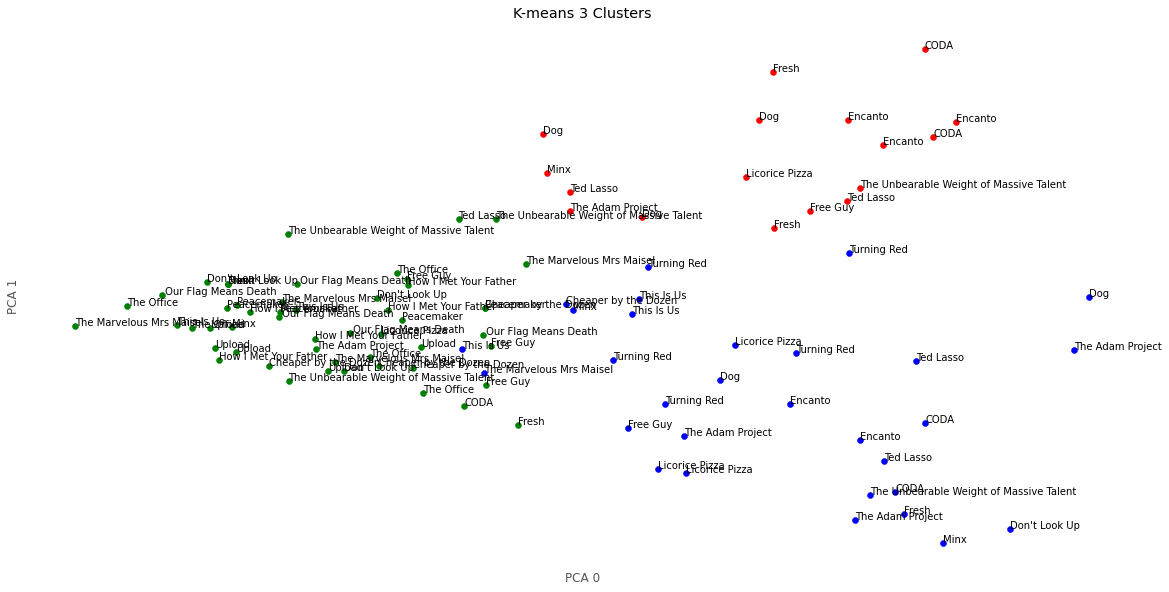

The top 21 words are ['character', 'characters', 'does', 'family', 'film', 'fun', 'funny', 'good', 'great', 'just', 'life', 'like', 'love', 'mother', 'movie', 'people', 'really', 'story', 'time', 'watch', 'way']


In [47]:
k3 = kmeans_clustering(movie_reviews, 3)
print(f'The top 21 words are {[i for i in k3[2].columns[2:]]}')

The Shape for the vectorized reviews (100, 21)


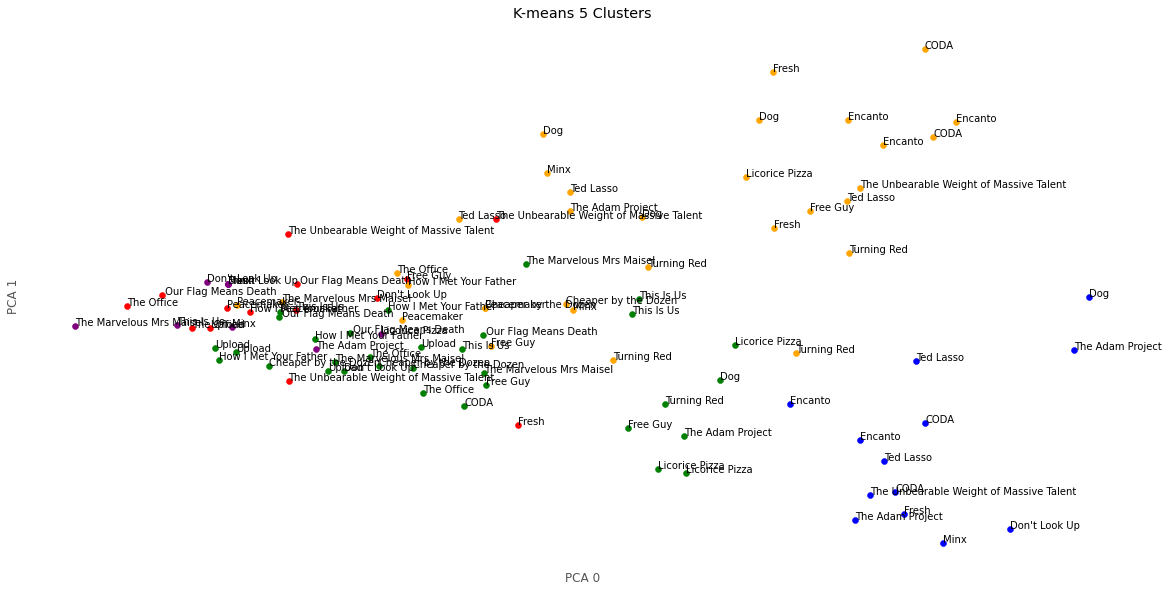

The top 21 words are ['character', 'characters', 'does', 'family', 'film', 'fun', 'funny', 'good', 'great', 'just', 'life', 'like', 'love', 'mother', 'movie', 'people', 'really', 'story', 'time', 'watch', 'way']


In [45]:
k5 = kmeans_clustering(movie_reviews, 5)
print(f'The top 21 words are {[i for i in k5[2].columns[2:]]}')

The Shape for the vectorized reviews (100, 21)


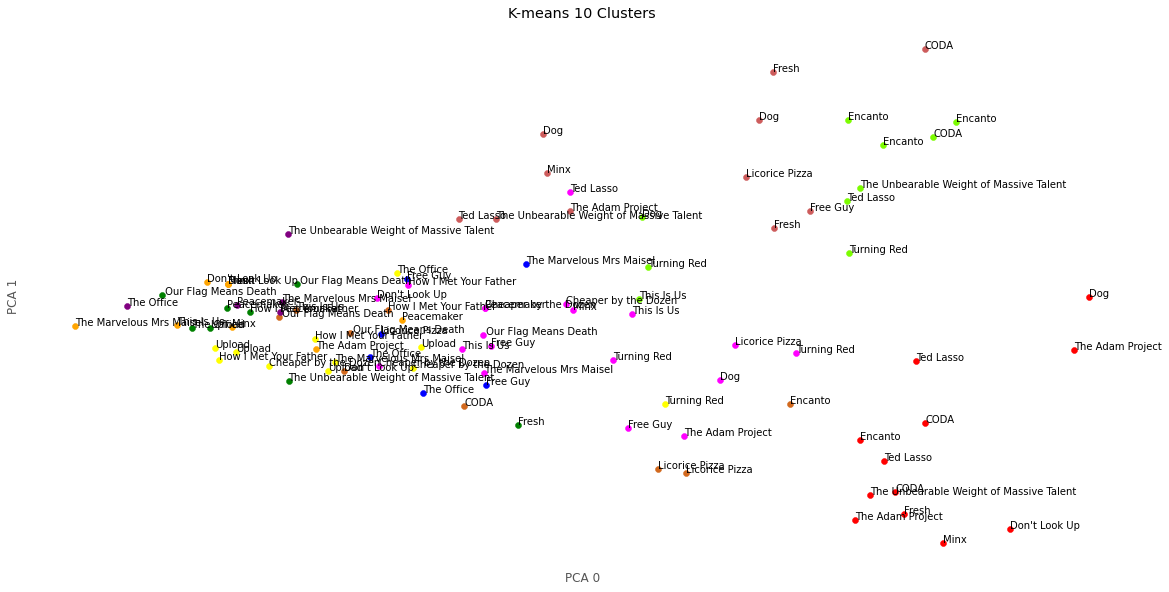

The top 21 words are ['character', 'characters', 'does', 'family', 'film', 'fun', 'funny', 'good', 'great', 'just', 'life', 'like', 'love', 'mother', 'movie', 'people', 'really', 'story', 'time', 'watch', 'way']


In [46]:
k10 = kmeans_clustering(movie_reviews, 10)
print(f'The top 21 words are {[i for i in k10[2].columns[2:]]}')

---

2.	Try to write a short phrase to characterize (give a natural interpretation of) what each cluster is generally centered on semantically. Is this hard to do in some cases? If so, make note of that fact. 

For the clusters, I limited the features to the top 21 words in each movie review. In order to plot the vectors I used PCA and converted my sparse vectors to dense vectors. I added titles to the plots to try and make sense of the clusters.




---

3.	Explain which of the two clustering results from question 1 is preferable (if one of them is), and why. 
 
k=3 seems to be best cluster and the easiest to read, while k=5 seems to also show signs of good separation until we get into the red and green dots, then it is hard to disinguish between the clusters.